In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle

In [3]:
num_datasets_per_comparison = {
'ATB_v_LTBI': 16,
'ATB_v_HC' : 15,
'ATB_v_OD': 10,
'LTBI_v_HC': 9}

#### set the *q-value* threshold & comparison

In [4]:
qval_thresh = 0.05

In [5]:
comparison_X = 'ATB_v_HC'

#### set parameters for plotting

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory where differential gene data is stored

In [7]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for O2 computing cluster
diff_exp_data_dir = "/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [8]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, linecolor):
    
    #convert Counter dict to series
    edge_weight_distr_series = pd.Series(edge_weight_distr_counter_dict).sort_index()
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = edge_weight_distr_series.index
    edge_weight_count = edge_weight_distr_series.values
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'white' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index <= -3] , edge_weight_count_norm[edge_weight_distr_series.index <= -3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index >= 3] , edge_weight_count_norm[edge_weight_distr_series.index >= 3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.plot(edge_weight_values , edge_weight_count_norm, color = linecolor , linewidth = 2.5)
    
    # calculate the number of the edges that had weight <= -3
    negative_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index <= -3].sum()
    
    # calculate the number of the edges that had weight >= 3
    positive_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index >= 3].sum()

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights \n (Num Edges <= -3: {negative_edge_weights_for_network}) \n (Num Edges >= 3: {positive_edge_weights_for_network})' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#### set parameters for plotting

In [9]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

## Compute Edges (and corresponding weights) from pooled logFC matrix

In [10]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

# read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

# Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
# +1 if logFC > 0
#  0 if logFC = 0
# -1 if logFC < 0

# store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

# replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

# convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

# compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
# Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$
# multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

# the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

# DISTRIBUTION OF EDGE WEIGHTS

#number of rows / columns
num_genes = np.shape(network_edge_weight_matrix)[0]

# retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]

#convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

In [11]:
network_edge_weight_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]], dtype=int8)

In [12]:
np.shape(network_edge_weight_matrix)

(30468, 30468)

In [68]:
network_edge_weight_matrix_labels.head()

0     KRT36
1     KIFC3
2      REG4
3     FADS2
4    FANCD2
dtype: object

In [69]:
np.shape(network_edge_weight_matrix_labels)

(30468,)

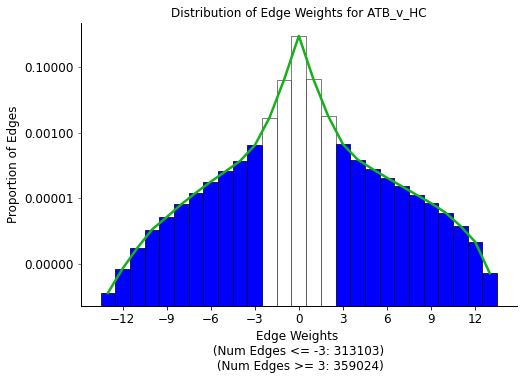

In [70]:
fig , ax = plt.subplots()

plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, f'Distribution of Edge Weights for {comparison_X}', 'xkcd:green')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### minimum/maximum edge weights

In [71]:
np.min(network_edge_weight_matrix)

-13

In [72]:
np.max(network_edge_weight_matrix)

13

## Construct NetworkX graph from edge weight matrix

#### Retrieve the indices for the upper-triangular part of the matrix, normalize edge weights & construct list of edges

Have to (1) retrieve the edges from the upper-triangle of the matrix, (2) convert all to positive edge weights & (3) divide by the number of datasets

In [73]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -3 OR >= 3
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 3

#get the indices for the elements in the upper triangle where elements (edge weights) <= -3 OR >= 3
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#get the normalization factor (number of datasets used to construct edge weights = maximum possible weight)
edge_weight_norm_factor = float(num_datasets_per_comparison[comparison_X])

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -3 OR >= 3
G_edge_list = [ ( network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], (float(abs(network_edge_weight_matrix[node_i, node_j]))/edge_weight_norm_factor) ) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [74]:
G_edge_list[0:10]

[('USB1', 'USB1', 0.3333333333333333),
 ('USB1', 'C12orf57', 0.26666666666666666),
 ('USB1', 'CD6', 0.26666666666666666),
 ('USB1', 'ZNF329', 0.2),
 ('USB1', 'BLVRA', 0.26666666666666666),
 ('USB1', 'CHMP5', 0.2),
 ('USB1', 'P2RY10', 0.2),
 ('USB1', 'TRIM32', 0.2),
 ('USB1', 'BCL3', 0.2),
 ('USB1', 'ACAD11', 0.2),
 ('USB1', 'ASGR1', 0.2),
 ('USB1', 'NBN', 0.26666666666666666),
 ('USB1', 'FBXO31', 0.2),
 ('USB1', 'TCN2', 0.26666666666666666),
 ('USB1', 'ZBTB9', 0.2),
 ('USB1', 'CA4', 0.26666666666666666),
 ('USB1', 'CNNM3', 0.2),
 ('USB1', 'FRMD3', 0.26666666666666666),
 ('USB1', 'HPSE', 0.3333333333333333),
 ('USB1', 'SARM1', 0.2)]

In [75]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -3 OR >= 3)

672127

#### Construct NetworkX graph from list of Edges

In [76]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [77]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3005
Number of edges: 672127
Average degree: 447.3391


## Visualize network

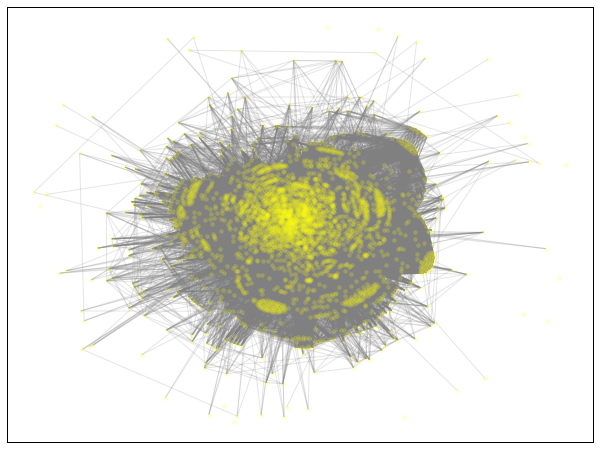

In [87]:
pos = nx.spring_layout(G, k=0.18)
plt.rcParams.update({'figure.figsize': (10.5, 8)})
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=15, 
    node_color = 'xkcd:yellow',
    edge_color="0.5",
    alpha=0.2, 
    with_labels=False)
plt.show()

## Centrality of Nodes from NetworkX graph

In [79]:
degree_centrality_series = pd.Series(nx.degree_centrality(G)).sort_values(ascending = False) #doesn't take edge weight into account
eigenvector_centrality_series = pd.Series(nx.eigenvector_centrality(G, weight = 'weight')).sort_values(ascending = False) #takes edge weight into account

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


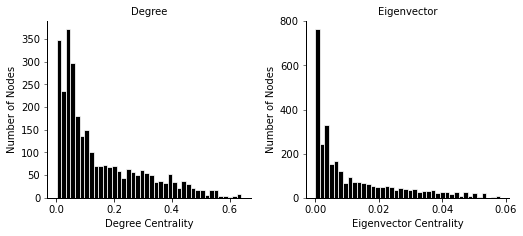

In [80]:
# PLOT DISTRIBUTIONS AND TAIL PROPORTIONS

fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#DEGREE CENTRALITY
ax1.hist(degree_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax1.set_title('Degree', fontsize = 10, color = 'k')
ax1.set_ylabel('Number of Nodes', fontsize = 10, color = 'k')
ax1.set_xlabel(f'Degree Centrality' , fontsize = 10, color = 'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(False)
ax1.tick_params(labelcolor = 'k')
ax1.tick_params(axis='y', which='major', labelsize=10 , labelcolor = 'k')
ax1.tick_params(axis='x', which='major', labelsize=10 , labelcolor = 'k')
    
#EIGENVECTOR CENTRALITY
ax2.hist(eigenvector_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax2.set_title('Eigenvector', fontsize = 10, color = 'k')
ax2.set_ylabel('Number of Nodes', fontsize = 10, color = 'k')
ax2.set_xlabel(f'Eigenvector Centrality' , fontsize = 10, color = 'k')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.tick_params(labelcolor = 'k')
ax2.tick_params(axis='y', which='major', labelsize=10 , labelcolor = 'k')
ax2.tick_params(axis='x', which='major', labelsize=10 , labelcolor = 'k')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(7.5, 3.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [81]:
degree_centrality_series.head(n=20)

AIM2        0.641478
SORT1       0.641478
GBP5        0.641478
PIK3IP1     0.641478
SAMD9L      0.641478
IFITM3      0.641478
CARD16      0.641478
ANKRD22     0.633822
SLC6A12     0.623835
BATF2       0.623835
SERPING1    0.618509
FCGR1B      0.607190
C1QB        0.600533
HP          0.591545
LY96        0.591545
EPB41L3     0.587883
CCR7        0.585220
KCNJ2       0.578895
DHRS3       0.576897
BST1        0.576897
dtype: float64

In [82]:
eigenvector_centrality_series.head(n=20)

GBP5       0.058306
AIM2       0.058306
SAMD9L     0.058306
CARD16     0.058306
SORT1      0.058306
IFITM3     0.058306
PIK3IP1    0.058306
ANKRD22    0.055686
TLR5       0.055415
GBP2       0.055415
GBP4       0.055415
CCR7       0.055081
FCGR1B     0.053619
KLRB1      0.053383
VAMP5      0.053383
DUSP3      0.053383
BATF2      0.053338
SLC6A12    0.053338
IFIT3      0.053082
IFIT2      0.053082
dtype: float64

How does the ranking of centrality values between **Degree** and **Eigenvector** centrality compare?

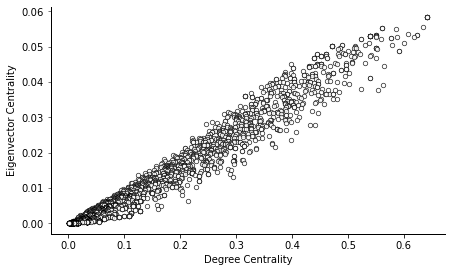

In [83]:
fig , ax = plt.subplots()

ax.scatter(degree_centrality_series[eigenvector_centrality_series.index], eigenvector_centrality_series , color = 'white' , linewidth=0.75 , edgecolor = 'black' , s = 20 , alpha = 0.8)

#ax.set_title('Degree vs. Eigenvector Centrality', fontsize = 10, color = 'k')
ax.set_ylabel('Eigenvector Centrality', fontsize = 10, color = 'k')
ax.set_xlabel('Degree Centrality' , fontsize = 10, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=10 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=10 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(6.5, 4.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [ ]:
for edge in eigenvector_centrality_series.head(n=200).index:
    print(edge)

Pathway enrichment analysis on the **top 200** genes (highest eigenvector centralities)

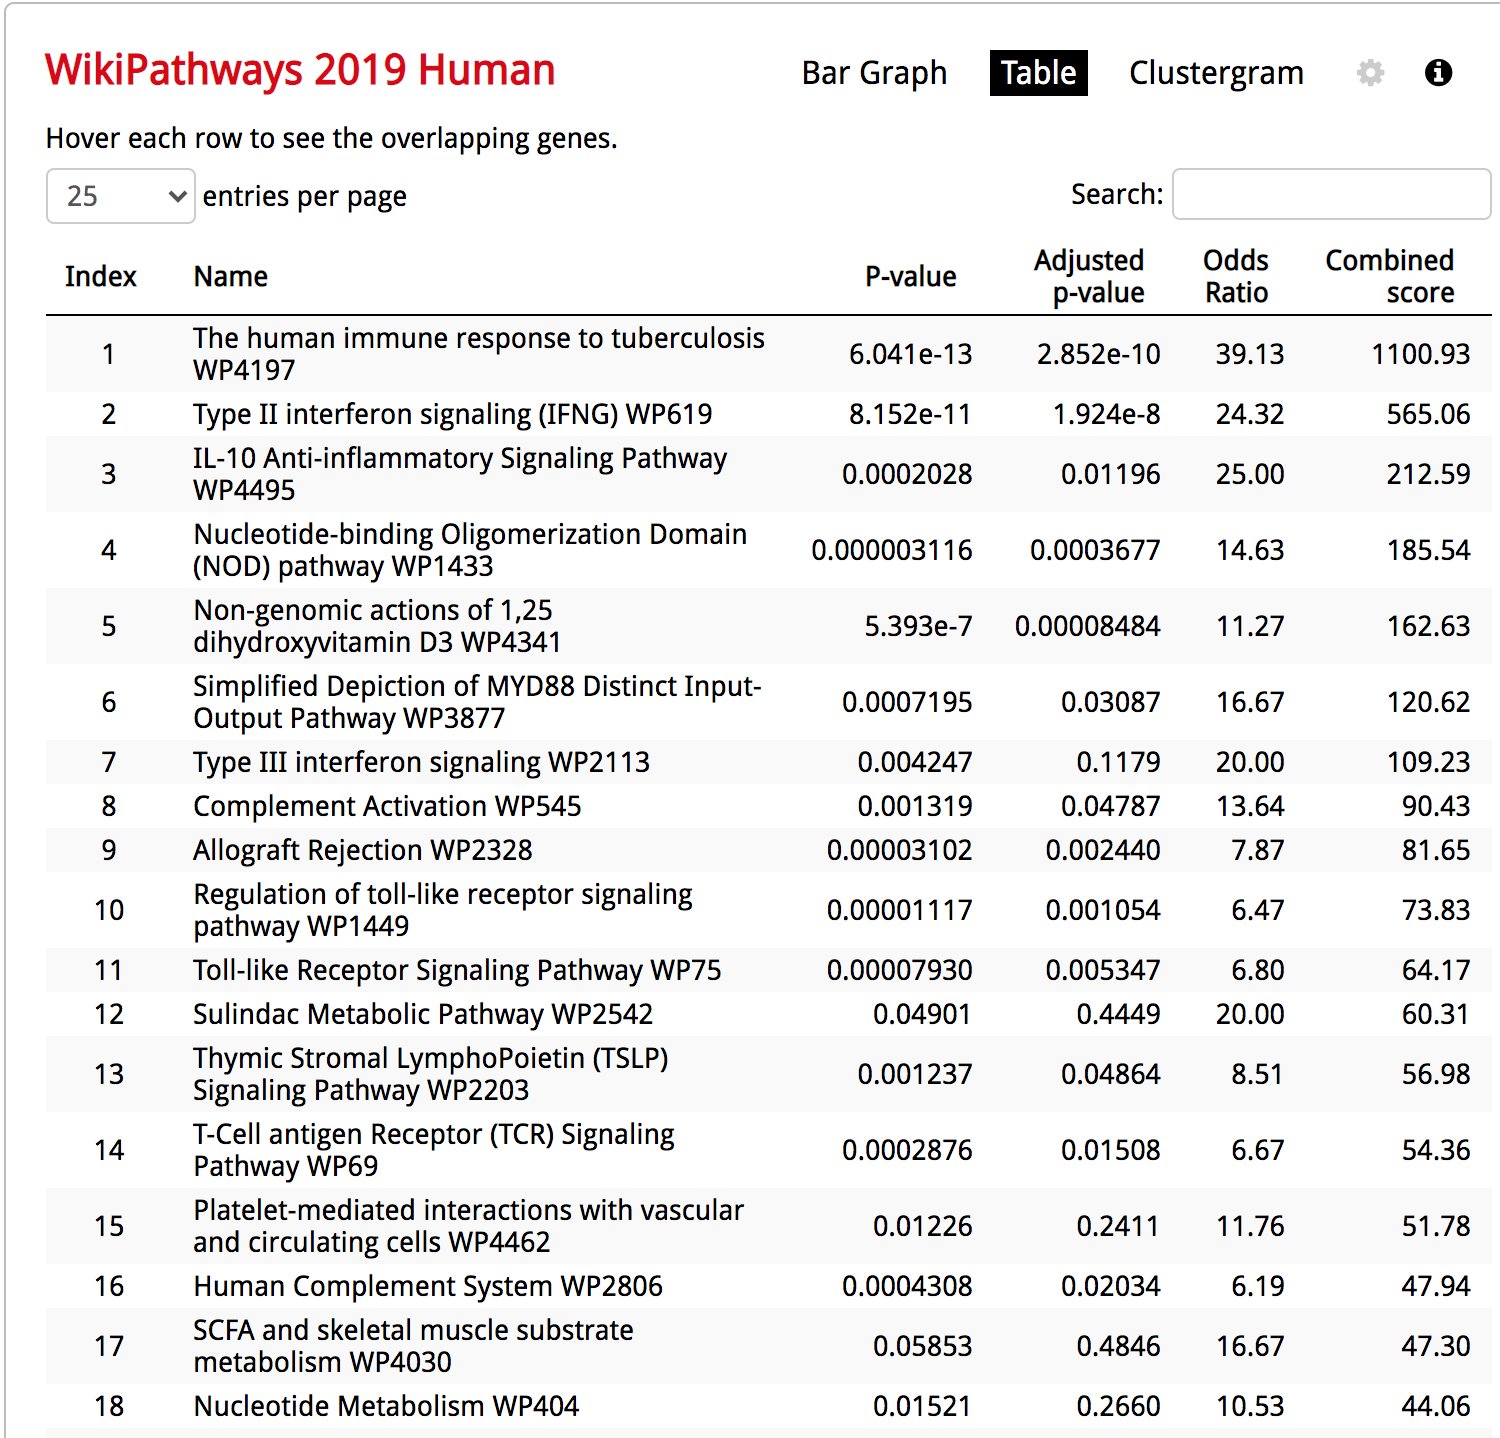

In [7]:
from IPython.display import Image
Image(filename='/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Jupyter Notebooks/images/ATB_v_HC_top_200_eigen_centrality_nodes.png', width = 600, height = 500)

## Communities in NetworkX graph

Find communities using the **Louvain** algorithm

Completed Louvain algorithm .. . . 
Modularity:  0.18196978580610143
Total number of Communities= 19


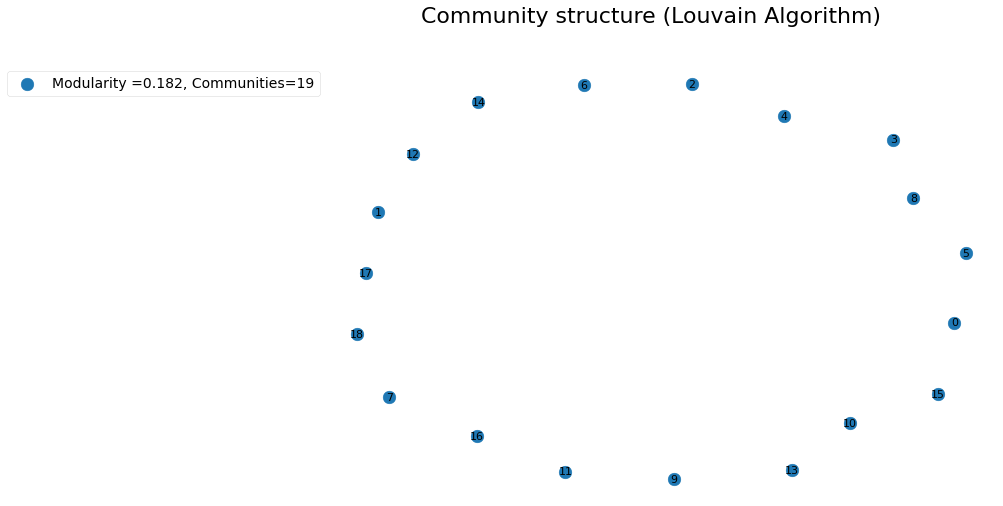

In [116]:
# Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
partition=community.best_partition(G, weight='weight')
print('Completed Louvain algorithm .. . . ' )
values=[partition.get(node) for node in G.nodes()]
list_com=partition.values()

# Creating a dictionary like {community_number:list_of_participants}
dict_nodes={}

# Populating the dictionary with items
for each_item in partition.items():
    community_num=each_item[1]
    community_node=each_item[0]
    if community_num in dict_nodes:
        value=dict_nodes.get(community_num) + ' | ' + str(community_node)
        dict_nodes.update({community_num:value})
    else:
        dict_nodes.update({community_num:community_node})

# Creating a dataframe from the dict, and getting the output into excel
community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
community_df.index.rename('Community_Num' , inplace=True)
num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
community_df.loc[: , 'Num_Members'] = num_comm_members
## community_df.to_csv('Community_List_snippet.csv')

# Creating a new graph to represent the communities created by the Louvain algorithm
plt.rcParams['figure.figsize']= [12, 8]
G_comm=nx.Graph()

# Populating the data from the node dictionary created earlier
G_comm.add_nodes_from(dict_nodes)

# Calculating modularity and the total number of communities
mod=community.modularity(partition,G)
print("Modularity: ", mod)
print("Total number of Communities=", len(G_comm.nodes()))

# Creating the Graph and also calculating Modularity
plt.rcParams['figure.figsize']= [12, 8]
pos_louvain=nx.spring_layout(G_comm)
nx.draw_networkx(G_comm, pos_louvain, with_labels=True,node_size=160,font_size=11,label='Modularity =' + str(round(mod,3)) +
                    ', Communities=' + str(len(G_comm.nodes())))
plt.suptitle('Community structure (Louvain Algorithm)',fontsize=22,fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
## plt.savefig('louvain.png',dpi=400, bbox_inches='tight')

In [117]:
community_df

,Members,Num_Members
Community_Num,,
0,USB1 | C12orf57 | ZNF329 | P2RY10 | TRIM32 | B...,769
1,CD6 | BLVRA | CHMP5 | NT5C3A | PLSCR1 | TIFA |...,411
2,NBN | SARM1 | PLA2G4A | STMN3 | IRAK3 | FGD4 |...,592
3,FBXO31 | CNNM3 | SERPING1 | CLEC4D | CALCOCO2 ...,555
4,LY9 | DHRS12 | SYTL2 | SMAD7 | GNLY | SIRPB1 |...,661
5,KRT23,1
6,KIAA0895L,1
7,PELP1,1
8,DUSP5,1


In [ ]:
for gene in community_df.loc[2, 'Members'].split(' | '):
    print(gene)

Can convert edge weight matrix into a dataframe with gene labels

In [127]:
network_edge_weight_df = nx.to_pandas_adjacency(G, dtype=float, weight = 'weight')

In [128]:
network_edge_weight_df.head()

,USB1,C12orf57,CD6,ZNF329,BLVRA,CHMP5,P2RY10,TRIM32,BCL3,ACAD11,...,BDP1,MUSTN1,RALGPS2,IGF1R,TBC1D24,HPS1,FAM86B3P,MANBAL,HBG1,HBG2
USB1,0.333333,0.266667,0.266667,0.200000,0.266667,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C12orf57,0.266667,0.600000,0.533333,0.266667,0.400000,0.533333,0.266667,0.266667,0.266667,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD6,0.266667,0.533333,0.733333,0.266667,0.600000,0.600000,0.333333,0.266667,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF329,0.200000,0.266667,0.266667,0.333333,0.266667,0.200000,0.200000,0.266667,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BLVRA,0.266667,0.400000,0.600000,0.266667,0.666667,0.533333,0.333333,0.000000,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
np.shape(network_edge_weight_df)